In [16]:
! pip install numpy

In [17]:
! pip install pyshark

In [18]:
! pip install pandas

In [19]:
! pip install matplotlib

In [20]:
! pip install seaborn

In [21]:
! sudo DEBIAN_FRONTEND=noninteractive apt install -y tshark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tshark is already the newest version (3.2.3-1).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.


In [22]:
! pip install scikit-learn

In [23]:
# Imports and Configuration
import struct
import numpy as np
import pyshark
import pandas as pd
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple, List, Optional
import nest_asyncio
from collections import defaultdict, deque
import struct
from typing import List, Tuple, Optional

nest_asyncio.apply()

# Configure plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("Libraries imported successfully!")

Libraries imported successfully!


In [24]:
# --- Updated ModbusSensorExtractor with EWMA & CUSUM ---
class ModbusSensorExtractor:
    def __init__(self, window_size: int = 16, ewma_alpha: float = 0.3, cusum_k_factor: float = 0.25):
        self.window_size = window_size
        self.ewma_alpha = ewma_alpha
        self.cusum_k_factor = cusum_k_factor

        self.sensor_data = defaultdict(lambda: {
            'timestamps': deque(maxlen=window_size),
            'readings': deque(maxlen=window_size),
            'sample_count': 0
        })
        self.pending_requests = {}
        self.total_readings = 0
        self.predictions_0 = 0
        self.predictions_1 = 0
        self.all_features = []
        self.feature_history = []

    # -----------------------------------------------------
    # --- Modbus parsing (same as your original code) ---
    # -----------------------------------------------------
    def parse_modbus_mbap(self, data: bytes) -> Optional[Tuple]:
        if len(data) < 7:
            return None
        return struct.unpack('>HHHB', data[:7])

    def parse_modbus_request(self, data: bytes) -> Optional[Tuple]:
        if len(data) < 5:
            return None
        return (data[0],) + struct.unpack('>HH', data[1:5])

    def parse_modbus_response(self, data: bytes) -> Optional[Tuple]:
        if len(data) < 2:
            return None
        return data[0], data[1]

    def extract_register_data(self, data: bytes, start_addr: int, num_registers: int):
        registers = []
        reg_idx = 0
        while reg_idx < num_registers:
            data_offset = 2 + (reg_idx * 2)
            if data_offset + 2 > len(data):
                break
            reg_hi = data[data_offset]
            reg_lo = data[data_offset + 1]
            regval = (reg_hi << 8) | reg_lo
            is_32bit = False
            sensor_value = 0
            actual_reg_addr = start_addr + reg_idx
            if num_registers >= 2 and reg_idx < num_registers - 1:
                next_reg_hi = data[data_offset + 2]
                next_reg_lo = data[data_offset + 3]
                next_regval = (next_reg_hi << 8) | next_reg_lo
                if regval == 0 and next_regval != 0:
                    combined_val = (regval << 16) | next_regval
                    sensor_value = np.int32(combined_val)
                    is_32bit = True
                    reg_idx += 1
                else:
                    sensor_value = np.int16(regval)
            else:
                sensor_value = np.int16(regval)
            registers.append((actual_reg_addr, sensor_value, is_32bit))
            reg_idx += 1
        return registers

    # -----------------------------------------------------
    # --- Feature helpers ---
    # -----------------------------------------------------
    def _compute_ewma(self, readings: np.ndarray) -> np.ndarray:
        """Compute EWMA series."""
        alpha = self.ewma_alpha
        ewma = np.zeros_like(readings, dtype=float)
        ewma[0] = readings[0]
        for i in range(1, len(readings)):
            ewma[i] = alpha * readings[i] + (1 - alpha) * ewma[i - 1]
        return ewma

    def _compute_cusum(self, readings: np.ndarray) -> np.ndarray:
        """Compute one-sided CUSUM for drift detection."""
        mean_ref = np.mean(readings)
        std_ref = np.std(readings)
        k = self.cusum_k_factor * (std_ref if std_ref > 0 else 1.0)
        pos_cusum = np.zeros_like(readings, dtype=float)
        s_pos = 0.0
        for i in range(1, len(readings)):
            s_pos = max(0.0, s_pos + (readings[i] - mean_ref - k))
            pos_cusum[i] = s_pos
        return pos_cusum

    def compute_slope_seconds(self, timestamps: List[float], readings: List[float]) -> float:
        n = len(readings)
        if n < 2:
            return 0.0
        t = np.array(timestamps) - timestamps[0]
        y = np.array(readings, dtype=float)
        A = np.vstack([t, np.ones(len(t))]).T
        slope, _ = np.linalg.lstsq(A, y, rcond=None)[0]
        return float(slope)

    def compute_sensor_features(self, timestamps: List[float], readings: List[float]) -> List[float]:
        """Compute raw + EWMA + CUSUM feature vector (16 values)."""
        if len(readings) != self.window_size:
            raise ValueError(f"Need exactly {self.window_size} samples, got {len(readings)}")

        readings_arr = np.array(readings, dtype=np.float32)
        timestamps_arr = np.array(timestamps)

        # --- Raw basic features (8) ---
        minv = np.min(readings_arr)
        maxv = np.max(readings_arr)
        mean = np.mean(readings_arr)
        range_val = maxv - minv

        iats = np.diff(timestamps_arr) * 1e6
        iat_min = np.min(iats) if len(iats) > 0 else 0
        iat_max = np.max(iats) if len(iats) > 0 else 0
        mean_iat = np.mean(iats) if len(iats) > 0 else 0

        slope = self.compute_slope_seconds(timestamps_arr, readings_arr)

        # --- EWMA (over readings) ---
        ewma_series = self._compute_ewma(readings_arr)
        ewma_mean = np.mean(ewma_series)
        ewma_min = np.min(ewma_series)
        ewma_max = np.max(ewma_series)
        ewma_range = ewma_max - ewma_min

        # --- CUSUM (over readings) ---
        cusum_series = self._compute_cusum(readings_arr)
        cusum_mean = np.mean(cusum_series)
        cusum_min = np.min(cusum_series)
        cusum_max = np.max(cusum_series)
        cusum_range = cusum_max - cusum_min

        features = [
            float(minv), float(maxv), float(mean),
            float(iat_min), float(iat_max), float(mean_iat),
            float(range_val), float(slope),
            float(ewma_mean), float(ewma_min), float(ewma_max), float(ewma_range),
            float(cusum_mean), float(cusum_min), float(cusum_max), float(cusum_range)
        ]
        return features

    # -----------------------------------------------------
    # --- Packet and window handling (same structure) ---
    # -----------------------------------------------------
    def process_packet(self, packet) -> List[Tuple]:
        sensor_readings = []
        try:
            timestamp = float(packet.sniff_time.timestamp())
            if not hasattr(packet, 'tcp'):
                return []
            src_port = int(packet.tcp.srcport)
            dst_port = int(packet.tcp.dstport)
            tcp_payload = bytes.fromhex(packet.tcp.payload.replace(':', ''))
            mbap = self.parse_modbus_mbap(tcp_payload)
            if not mbap:
                return []
            trans_id, protocol_id, length, unit_id = mbap
            pdu_data = tcp_payload[7:]

            # Request
            if src_port != 502 and dst_port == 502:
                if len(pdu_data) >= 5:
                    request = self.parse_modbus_request(pdu_data)
                    if request:
                        function_code, start_addr, quantity = request
                        if function_code in [0x03, 0x04]:
                            self.pending_requests[trans_id] = {
                                'unit_id': unit_id,
                                'start_addr': start_addr,
                                'num_registers': quantity,
                                'timestamp': timestamp
                            }

            # Response
            elif src_port == 502 and dst_port != 502:
                if len(pdu_data) >= 2:
                    response = self.parse_modbus_response(pdu_data)
                    if response:
                        function_code, byte_count = response
                        if function_code in [0x03, 0x04] and trans_id in self.pending_requests:
                            req = self.pending_requests[trans_id]
                            num_registers = byte_count // 2
                            registers = self.extract_register_data(pdu_data, req['start_addr'], num_registers)
                            for reg_addr, sensor_value, is_32bit in registers:
                                sensor_key = (unit_id, reg_addr)
                                sensor_readings.append((sensor_key, sensor_value, timestamp, is_32bit))
                            del self.pending_requests[trans_id]
        except Exception:
            return sensor_readings
        return sensor_readings

    def add_sensor_reading(self, sensor_key: Tuple, reading: int, timestamp: float, is_32bit: bool):
        sensor_id = self.sensor_data[sensor_key]
        self.total_readings += 1
        sensor_id['timestamps'].append(timestamp)
        sensor_id['readings'].append(reading)
        sensor_id['sample_count'] += 1

        if len(sensor_id['readings']) == self.window_size:
            features = self.compute_sensor_features(
                list(sensor_id['timestamps']), list(sensor_id['readings'])
            )
            feature_info = {
                'sensor_key': sensor_key,
                'features': features.copy(),
                'timestamp': timestamp,
                'readings': list(sensor_id['readings']),
                'timestamps': list(sensor_id['timestamps'])
            }
            self.feature_history.append(feature_info)
            sensor_id['timestamps'].clear()
            sensor_id['readings'].clear()
            sensor_id['sample_count'] = 0
            return features, sensor_key
        return None, sensor_key

    def get_statistics(self):
        return {
            'total_readings': self.total_readings,
            'unique_sensors': len(self.sensor_data),
            'feature_windows': len(self.feature_history),
            'pending_requests': len(self.pending_requests),
            'window_size': self.window_size
        }

print("✅ ModbusSensorExtractor with EWMA & CUSUM (16 features) defined!")


✅ ModbusSensorExtractor with EWMA & CUSUM (16 features) defined!


In [25]:
# Initialize and Test with Different Window Sizes
# Test different window sizes
window_sizes = [4, 8, 16, 32]
extractors = {}

for ws in window_sizes:
    extractors[ws] = ModbusSensorExtractor(window_size=ws)
    print(f"Initialized extractor with window size: {ws}")

print(f"\nAvailable extractors: {list(extractors.keys())}")

Initialized extractor with window size: 4
Initialized extractor with window size: 8
Initialized extractor with window size: 16
Initialized extractor with window size: 32

Available extractors: [4, 8, 16, 32]


In [26]:
# Process PCAP File (updated for 16 features)

def process_pcap_file(pcap_path, extractor, max_packets=1000, verbose=False):
    """Process PCAP file with given extractor (expects extractor.compute_sensor_features -> 16 features)."""
    print(f"Processing {pcap_path} with window size {extractor.window_size}...")
    
    all_features_data = []
    packet_count = 0
    features_count = 0
    cap = None
    
    try:
        # Open PCAP file (filter Modbus/TCP)
        cap = pyshark.FileCapture(pcap_path, display_filter='tcp.port == 502')
        
        for packet in cap:
            if max_packets > 0 and packet_count >= max_packets:
                break
                
            packet_count += 1
            
            # Extract sensor readings from packet
            sensor_readings = extractor.process_packet(packet)
            
            # Each sensor_reading -> (sensor_key, reading, timestamp, is_32bit)
            for sensor_key, reading, timestamp, is_32bit in sensor_readings:
                features, key = extractor.add_sensor_reading(sensor_key, reading, timestamp, is_32bit)
                
                if features is not None:
                    unit_id, reg_addr = key
                    # Insert unit/reg first, then 16 features
                    feature_row = [unit_id, reg_addr] + list(features)
                    all_features_data.append(feature_row)
                    features_count += 1
                    
                    if verbose:
                        # show a few representative fields: mean (idx 2), range (idx 6), ewma_mean (idx 8), cusum_max (idx 14)
                        mean_val = features[2] if len(features) > 2 else float('nan')
                        range_val = features[6] if len(features) > 6 else float('nan')
                        ewma_mean = features[8] if len(features) > 8 else float('nan')
                        cusum_max = features[14] if len(features) > 14 else float('nan')
                        print(f"✓ Features extracted - Sensor ({unit_id},{reg_addr}) - "
                              f"mean={mean_val:.3f} range={range_val:.3f} "
                              f"ewma_mean={ewma_mean:.3f} cusum_max={cusum_max:.3f}")
            
            if packet_count % 500 == 0 and verbose:
                print(f"Processed {packet_count} packets...")
                
    except Exception as e:
        print(f"Error reading PCAP file: {e}")
        # Ensure capture closed below
    finally:
        if cap is not None:
            try:
                cap.close()
            except Exception:
                pass
    
    # Create DataFrame with appropriate 16-feature columns
    if all_features_data:
        df = pd.DataFrame(all_features_data, columns=[
            'unit_id', 'reg_addr',
            'min', 'max', 'mean',
            'iat_min_us', 'iat_max_us', 'mean_iat_us',
            'range', 'slope',
            'ewma_mean', 'ewma_min', 'ewma_max', 'ewma_range',
            'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'
        ])
        
        print(f"\n✅ Processing Complete!")
        print(f"Packets processed: {packet_count}")
        print(f"Feature windows extracted: {features_count}")
        print(f"Unique sensors found: {len(extractor.sensor_data)}")
        
        return df
    else:
        print("❌ No features extracted - check if PCAP contains Modbus/TCP traffic")
        return None


### Exp 1: accuracy at different window sizes (4,8,16,32) for MLP with 8 features
also (MLP 16f, RF 8f and RF 16f)  

In [27]:
pcap_path = "/home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap"
df_normal_4 = process_pcap_file(pcap_path, extractors[4], max_packets=1000000)
print(df_normal_4.columns)
print(df_normal_4.head())
pcap_path = "/home/ubuntu/raw_data/fault/faults_traffic_2025-01-10_03_22_36.pcap"
df_fault_4 = process_pcap_file(pcap_path, extractors[4], max_packets=1000000)
print(df_fault_4.columns)
print(df_fault_4.head())
df_normal_4.to_csv("normal_ws4.csv", index=False)
df_fault_4.to_csv("fault_ws4.csv", index=False)
# df_normal_4 = pd.read_csv("normal_ws4.csv")
# df_fault_4 = pd.read_csv("fault_ws4.csv")

Processing /home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap with window size 4...


/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 48928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 33928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r

KeyboardInterrupt: 

In [ ]:
df_normal = df_normal_4
df_fault = df_fault_4

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# --- 5) pipeline: scaler + MLP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=1000,
        random_state=42
    ))
])

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = pipe.predict(X_test)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred,digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass


Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max', 'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']
Class counts:
 label
1    148533
0    126810
Name: count, dtype: int64

Classification report (test):
              precision    recall  f1-score   support

           0     0.8849    0.7201    0.7941     25362
           1     0.7938    0.9201    0.8523     29707

    accuracy                         0.8280     55069
   macro avg     0.8394    0.8201    0.8232     55069
weighted avg     0.8358    0.8280    0.8255     55069

Confusion matrix:
[[18264  7098]
 [ 2375 27332]]
ROC AUC: 0.9059132324217322


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# --- 5) pipeline: scaler + MLP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=1000,
        random_state=42
    ))
])

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = pipe.predict(X_test)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred,digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass


Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope']
Class counts:
 label
1    148533
0    126810
Name: count, dtype: int64

Classification report (test):
              precision    recall  f1-score   support

           0     0.8697    0.7268    0.7919     25362
           1     0.7955    0.9071    0.8476     29707

    accuracy                         0.8240     55069
   macro avg     0.8326    0.8169    0.8197     55069
weighted avg     0.8297    0.8240    0.8219     55069

Confusion matrix:
[[18433  6929]
 [ 2761 26946]]
ROC AUC: 0.90410503268514


In [ ]:
pcap_path = "/home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap"
df_normal_8 = process_pcap_file(pcap_path, extractors[8], max_packets=1000000)
print(df_normal_8.columns)
print(df_normal_8.head())
pcap_path = "/home/ubuntu/raw_data/fault/faults_traffic_2025-01-10_03_22_36.pcap"
df_fault_8 = process_pcap_file(pcap_path, extractors[8], max_packets=1000000)
print(df_fault_8.columns)
print(df_fault_8.head())
df_normal_8.to_csv("normal_ws8.csv", index=False)
df_fault_8.to_csv("fault_ws8.csv", index=False)
# df_normal_8 = pd.read_csv("normal_ws8.csv")
# df_fault_8 = pd.read_csv("fault_ws8.csv")

df_normal = df_normal_8
df_fault = df_fault_8

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# --- 5) pipeline: scaler + MLP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=1000,
        random_state=42
    ))
])

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = pipe.predict(X_test)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred,digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass


Processing /home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap with window size 8...


/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 48928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 33928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r


✅ Processing Complete!
Packets processed: 1000000
Feature windows extracted: 63401
Unique sensors found: 22
Index(['unit_id', 'reg_addr', 'min', 'max', 'mean', 'iat_min_us', 'iat_max_us',
       'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
      dtype='object')
   unit_id  reg_addr      min      max     mean    iat_min_us     iat_max_us  \
0        1        20   2266.0   3600.0   2933.0  14489.889145  202371.120453   
1        1        14      1.0      1.0      1.0  14170.169830  202106.952667   
2        1        24      0.0      0.0      0.0  14604.091644  202116.012573   
3        1        25      0.0      0.0      0.0  14604.091644  202116.012573   
4        1        22  18000.0  18000.0  18000.0  13091.087341  202329.874039   

     mean_iat_us   range         slope     ewma_mean  ewma_min      ewma_max  \
0  142815.555845  1334.0  1.323398e+03   2663.269842    2266.0   3190.7891

/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 39104 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 64464 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r


✅ Processing Complete!
Packets processed: 1000000
Feature windows extracted: 74261
Unique sensors found: 22
Index(['unit_id', 'reg_addr', 'min', 'max', 'mean', 'iat_min_us', 'iat_max_us',
       'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
      dtype='object')
   unit_id  reg_addr     min      max      mean   iat_min_us    iat_max_us  \
0        1        11     0.0      0.0     0.000  2753.019333  1.065050e+10   
1        1        21     0.0      0.0     0.000  2706.050873  1.066151e+10   
2        1         9  4464.0   5901.0  5541.750  2125.978470  1.065050e+10   
3        1        14     0.0     11.0     4.125  5796.194077  1.065030e+10   
4        1        20     0.0  14400.0  7200.000  5795.955658  1.065030e+10   

    mean_iat_us    range     slope     ewma_mean  ewma_min   ewma_max  \
0  1.523285e+09      0.0  0.000000      0.000000      0.00      0.000   
1  1.523187e+09     

In [ ]:
pcap_path = "/home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap"
df_normal_16 = process_pcap_file(pcap_path, extractors[16], max_packets=1000000)
print(df_normal_16.columns)
print(df_normal_16.head())
pcap_path = "/home/ubuntu/raw_data/fault/faults_traffic_2025-01-10_03_22_36.pcap"
df_fault_16 = process_pcap_file(pcap_path, extractors[16], max_packets=1000000)
print(df_fault_16.columns)
print(df_fault_16.head())
df_normal_16.to_csv("normal_ws16.csv", index=False)
df_fault_16.to_csv("fault_ws16.csv", index=False)
# df_normal_16 = pd.read_csv("normal_ws16.csv")
# df_fault_16 = pd.read_csv("fault_ws16.csv")

df_normal = df_normal_16
df_fault = df_fault_16

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# --- 5) pipeline: scaler + MLP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=1000,
        random_state=42
    ))
])

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = pipe.predict(X_test)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred,digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass


Processing /home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap with window size 16...


/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 48928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 33928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r


✅ Processing Complete!
Packets processed: 1000000
Feature windows extracted: 31693
Unique sensors found: 22
Index(['unit_id', 'reg_addr', 'min', 'max', 'mean', 'iat_min_us', 'iat_max_us',
       'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
      dtype='object')
   unit_id  reg_addr      min      max        mean    iat_min_us  \
0        1        14      1.0      1.0      1.0000  14170.169830   
1        1        20   2266.0   5333.0   3707.9375  14489.889145   
2        1        22  18000.0  18000.0  18000.0000  13091.087341   
3        1        24      0.0      0.0      0.0000  14604.091644   
4        1        25      0.0      0.0      0.0000  14604.091644   

      iat_max_us    mean_iat_us   range         slope     ewma_mean  ewma_min  \
0  208519.935608  140408.468246     0.0  1.522161e-16      1.000000       1.0   
1  203454.971313  140502.595901  3067.0  1.362937e+03   3346.694

/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 39104 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 64464 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r


✅ Processing Complete!
Packets processed: 1000000
Feature windows extracted: 37134
Unique sensors found: 22
Index(['unit_id', 'reg_addr', 'min', 'max', 'mean', 'iat_min_us', 'iat_max_us',
       'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
      dtype='object')
   unit_id  reg_addr      min      max        mean   iat_min_us    iat_max_us  \
0        1        11      0.0      0.0      0.0000  1802.921295  1.065050e+10   
1        1         9   4464.0   5901.0   5721.3750  2125.978470  1.065050e+10   
2        1         0      0.0  10000.0   1250.0000  2077.817917  1.065050e+10   
3        1         2  30000.0  30000.0  30000.0000  2121.925354  1.065050e+10   
4        1         4  57166.0  59606.0  57906.6875  2123.832703  1.065050e+10   

    mean_iat_us    range         slope     ewma_mean      ewma_min  \
0  7.109995e+08      0.0  0.000000e+00      0.000000      0.000000   
1  7.102

In [ ]:
pcap_path = "/home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap"
df_normal_32 = process_pcap_file(pcap_path, extractors[32], max_packets=1000000)
print(df_normal_32.columns)
print(df_normal_32.head())
pcap_path = "/home/ubuntu/raw_data/fault/faults_traffic_2025-01-10_03_22_36.pcap"
df_fault_32 = process_pcap_file(pcap_path, extractors[32], max_packets=1000000)
print(df_fault_32.columns)
print(df_fault_32.head())
df_normal_32.to_csv("normal_ws32.csv", index=False)
df_fault_32.to_csv("fault_ws32.csv", index=False)
# df_normal_32 = pd.read_csv("normal_ws32.csv")
# df_fault_32 = pd.read_csv("fault_ws32.csv")

df_normal = df_normal_32
df_fault = df_fault_32

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# --- 5) pipeline: scaler + MLP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=1000,
        random_state=42
    ))
])

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = pipe.predict(X_test)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred,digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass


Processing /home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap with window size 32...


/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 48928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 33928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r


✅ Processing Complete!
Packets processed: 1000000
Feature windows extracted: 15843
Unique sensors found: 22
Index(['unit_id', 'reg_addr', 'min', 'max', 'mean', 'iat_min_us', 'iat_max_us',
       'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
      dtype='object')
   unit_id  reg_addr      min      max         mean   iat_min_us  \
0        1        20   2266.0   8133.0   5241.34375  8415.937424   
1        1        24      0.0      0.0      0.00000  7618.188858   
2        1        25      0.0      0.0      0.00000  7618.188858   
3        1        22  18000.0  18000.0  18000.00000  4292.011261   
4        1        14      1.0      1.0      1.00000  3010.034561   

      iat_max_us    mean_iat_us   range         slope     ewma_mean  ewma_min  \
0  207087.993622  142005.966556  5867.0  1.346000e+03   4841.143125    2266.0   
1  207062.005997  142002.928642     0.0  0.000000e+00      0.000

/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 39104 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 64464 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r


✅ Processing Complete!
Packets processed: 1000000
Feature windows extracted: 18566
Unique sensors found: 22
Index(['unit_id', 'reg_addr', 'min', 'max', 'mean', 'iat_min_us', 'iat_max_us',
       'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
      dtype='object')
   unit_id  reg_addr      min      max       mean   iat_min_us    iat_max_us  \
0        1        11      0.0      0.0     0.0000  1802.921295  1.065050e+10   
1        1         9   4464.0   5901.0  5811.1875   152.111053  1.065050e+10   
2        1        15 -26432.0  29104.0  -742.5000  1801.013947  1.065030e+10   
3        1         1      0.0      0.0     0.0000  2077.817917  1.065150e+10   
4        1         0      0.0  10000.0  5000.0000  2077.817917  1.065050e+10   

    mean_iat_us    range     slope    ewma_mean  ewma_min     ewma_max  \
0  3.445159e+08      0.0  0.000000     0.000000      0.00     0.000000   
1  3.4

#### pull csv and test mlp / rf with all ws


In [55]:
df_normal = pd.read_csv("normal_ws32.csv")
df_fault = pd.read_csv("fault_ws32.csv")

In [56]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# --- 5) pipeline: scaler + MLP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=1000,
        random_state=42
    ))
])

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = pipe.predict(X_test)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred,digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass


Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max', 'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']
Class counts:
 label
1    18566
0    15843
Name: count, dtype: int64

Classification report (test):
              precision    recall  f1-score   support

           0     0.9347    0.6412    0.7606      3169
           1     0.7585    0.9618    0.8481      3713

    accuracy                         0.8142      6882
   macro avg     0.8466    0.8015    0.8044      6882
weighted avg     0.8396    0.8142    0.8078      6882

Confusion matrix:
[[2032 1137]
 [ 142 3571]]
ROC AUC: 0.8628783910793502


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# (a) Train and evaluate Random Forest
rf_model = RandomForestClassifier(
    max_depth=20,
    n_estimators=5,
    #max_leaf_nodes=750,
    n_jobs=4,
    random_state=42,
    bootstrap=False
)

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf_model.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("(a) Model Evaluation")
print(f"Accuracy on test data: {accuracy:.6f}")
print(classification_report(y_test, y_pred, digits=4))
rf_accuracy = accuracy_score(y_test, y_pred)
rf_report = classification_report(y_test, y_pred,digits=4)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass

# (b) Feature Importances
importances = rf_model.feature_importances_
feature_importances = (
    pd.DataFrame({'feature': numeric_cols, 'importance': importances})
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print("\n(b) Feature Importances")
print(feature_importances)

Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope']
Class counts:
 label
1    18566
0    15843
Name: count, dtype: int64
(a) Model Evaluation
Accuracy on test data: 0.879105
              precision    recall  f1-score   support

           0     0.9113    0.8170    0.8616      3169
           1     0.8565    0.9321    0.8927      3713

    accuracy                         0.8791      6882
   macro avg     0.8839    0.8746    0.8771      6882
weighted avg     0.8817    0.8791    0.8784      6882

Confusion matrix:
[[2589  580]
 [ 252 3461]]
ROC AUC: 0.9468319245736432

(b) Feature Importances
       feature  importance
0  mean_iat_us    0.320625
1   iat_max_us    0.251434
2   iat_min_us    0.195830
3         mean    0.073569
4          max    0.049745
5          min    0.049622
6        range    0.034729
7        slope    0.024447


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# (a) Train and evaluate Random Forest
rf_model = RandomForestClassifier(
    max_depth=20,
    n_estimators=5,
    #max_leaf_nodes=750,
    n_jobs=4,
    random_state=42,
    bootstrap=False
)

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf_model.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("(a) Model Evaluation")
print(f"Accuracy on test data: {accuracy:.6f}")
print(classification_report(y_test, y_pred, digits=4))
rf_accuracy = accuracy_score(y_test, y_pred)
rf_report = classification_report(y_test, y_pred,digits=4)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass

# (b) Feature Importances
importances = rf_model.feature_importances_
feature_importances = (
    pd.DataFrame({'feature': numeric_cols, 'importance': importances})
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print("\n(b) Feature Importances")
print(feature_importances)

Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max', 'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']
Class counts:
 label
1    18566
0    15843
Name: count, dtype: int64
(a) Model Evaluation
Accuracy on test data: 0.890584
              precision    recall  f1-score   support

           0     0.9281    0.8264    0.8743      3169
           1     0.8645    0.9453    0.9031      3713

    accuracy                         0.8906      6882
   macro avg     0.8963    0.8859    0.8887      6882
weighted avg     0.8938    0.8906    0.8899      6882

Confusion matrix:
[[2619  550]
 [ 203 3510]]
ROC AUC: 0.9560750748502294

(b) Feature Importances
        feature  importance
0   mean_iat_us    0.298817
1    iat_max_us    0.249205
2    iat_min_us    0.173395
3     ewma_mean    0.041253
4           max    0.038404
5           min    0.031382
6      ewma_min    0.028403
7          mean    0.02

### Exp 2: accuracy at different tree sizes and window sizesfor RF wih 8 features  

In [96]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# datasets and feature set
datasets = {
    "ws4": ("normal_ws4.csv", "fault_ws4.csv"),
    "ws8": ("normal_ws8.csv", "fault_ws8.csv"),
    "ws16": ("normal_ws16.csv", "fault_ws16.csv"),
    "ws32": ("normal_ws32.csv", "fault_ws32.csv"),
}

numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']

depths = [10, 20, 50, 100]
estimators = [5, 10, 50, 100]

# results container
rows = []

# ensure output dir
out_dir = "trained_models"
os.makedirs(out_dir, exist_ok=True)

for ds_name, (normal_file, fault_file) in datasets.items():
    print(f"\n=== Processing dataset: {ds_name} (files: {normal_file}, {fault_file}) ===")
    # check files exist
    if not (os.path.exists(normal_file) and os.path.exists(fault_file)):
        print(f"  SKIP: Missing file(s) for {ds_name}. Found normal: {os.path.exists(normal_file)}, fault: {os.path.exists(fault_file)}")
        continue

    # load
    df_normal = pd.read_csv(normal_file)
    df_fault  = pd.read_csv(fault_file)

    # label and combine
    df_normal = df_normal.copy(); df_fault = df_fault.copy()
    df_normal['label'] = 0
    df_fault['label']  = 1
    df = pd.concat([df_normal, df_fault], ignore_index=True)

    # drop identifier columns if present (and the extra columns you removed earlier)
    df = df.drop(columns=['unit_id', 'reg_addr',
                          'ewma_mean', 'ewma_min', 'ewma_max', 'ewma_range',
                          'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
                 errors='ignore')

    # ensure numeric columns
    for c in numeric_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # drop missing
    df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

    print("  Using features:", numeric_cols)
    print("  Class counts:\n", df['label'].value_counts().to_string())

    # prepare
    X = df[numeric_cols]
    y = df['label'].astype(int)

    # train/test split once per dataset (fixed)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # iterate hyperparam grid
    for max_depth in depths:
        for n_est in estimators:
            rf = RandomForestClassifier(
                max_depth=max_depth,
                n_estimators=n_est,
                n_jobs=4,
                random_state=42,
                bootstrap=False
            )
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)

            # roc auc if possible
            roc = None
            try:
                y_prob = rf.predict_proba(X_test)[:, 1]
                roc = roc_auc_score(y_test, y_prob)
            except Exception:
                roc = np.nan

            # tree sizes
            total_nodes = 0
            for tree in rf.estimators_:
                total_nodes += tree.tree_.node_count
            avg_nodes = total_nodes / len(rf.estimators_)

            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            rows.append({
                "dataset": ds_name,
                "max_depth": max_depth,
                "n_estimators": n_est,
                "accuracy": acc,
                "roc_auc": roc,
                "avg_nodes_per_tree": avg_nodes,
                "total_nodes": total_nodes,
                "tn": int(tn),
                "fp": int(fp),
                "fn": int(fn),
                "tp": int(tp),
                "n_test_samples": len(y_test)
            })

            # --- Save the trained model to pickle ---
            model_filename = f"rf_{ds_name}_depth{max_depth}_est{n_est}.pkl"
            model_path = os.path.join(out_dir, model_filename)
            try:
                with open(model_path, "wb") as f:
                    pickle.dump(rf, f)
                print(f"  Saved model -> {model_path}")
            except Exception as e:
                print(f"  ERROR saving model {model_path}: {e}")

            print(f"  [{ds_name}] depth={max_depth:3d}, est={n_est:3d} -> acc={acc:.4f}, roc_auc={np.nan if np.isnan(roc) else f'{roc:.4f}'}, avg_nodes={avg_nodes:.1f}")

# optionally write the results summary csv
results_df = pd.DataFrame(rows)
results_df.to_csv("rf_grid_search_results.csv", index=False)
print("\nWrote rf_grid_search_results.csv")




=== Processing dataset: ws4 (files: normal_ws4.csv, fault_ws4.csv) ===
  Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope']
  Class counts:
 label
1    148533
0    126810
  Saved model -> trained_models/rf_ws4_depth10_est5.pkl
  [ws4] depth= 10, est=  5 -> acc=0.8425, roc_auc=0.9199, avg_nodes=480.2
  Saved model -> trained_models/rf_ws4_depth10_est10.pkl
  [ws4] depth= 10, est= 10 -> acc=0.8436, roc_auc=0.9217, avg_nodes=464.6
  Saved model -> trained_models/rf_ws4_depth10_est50.pkl
  [ws4] depth= 10, est= 50 -> acc=0.8447, roc_auc=0.9216, avg_nodes=440.2
  Saved model -> trained_models/rf_ws4_depth10_est100.pkl
  [ws4] depth= 10, est=100 -> acc=0.8439, roc_auc=0.9217, avg_nodes=439.1
  Saved model -> trained_models/rf_ws4_depth20_est5.pkl
  [ws4] depth= 20, est=  5 -> acc=0.8633, roc_auc=0.9403, avg_nodes=9213.4
  Saved model -> trained_models/rf_ws4_depth20_est10.pkl
  [ws4] depth= 20, est= 10 -> acc=0.8660, roc_auc=0.9438, avg_nodes



=== Summary of results ===
dataset  max_depth  n_estimators  accuracy  roc_auc  avg_nodes_per_tree  total_nodes
   ws16         10             5  0.853552 0.930972              383.40       1917.0
   ws16         10            10  0.850864 0.932725              382.40       3824.0
   ws16         10            50  0.850937 0.934690              383.48      19174.0
   ws16         10           100  0.852245 0.934932              383.34      38334.0
   ws16         20             5  0.876871 0.947737             4784.20      23921.0
   ws16         20            10  0.880285 0.951653             4954.60      49546.0
   ws16         20            50  0.882101 0.953639             4872.72     243636.0
   ws16         20           100  0.882319 0.953470             4914.56     491456.0
   ws16         50             5  0.881520 0.939779            15253.00      76265.0
   ws16         50            10  0.887476 0.951272            15413.20     154132.0
   ws16         50            50  0.

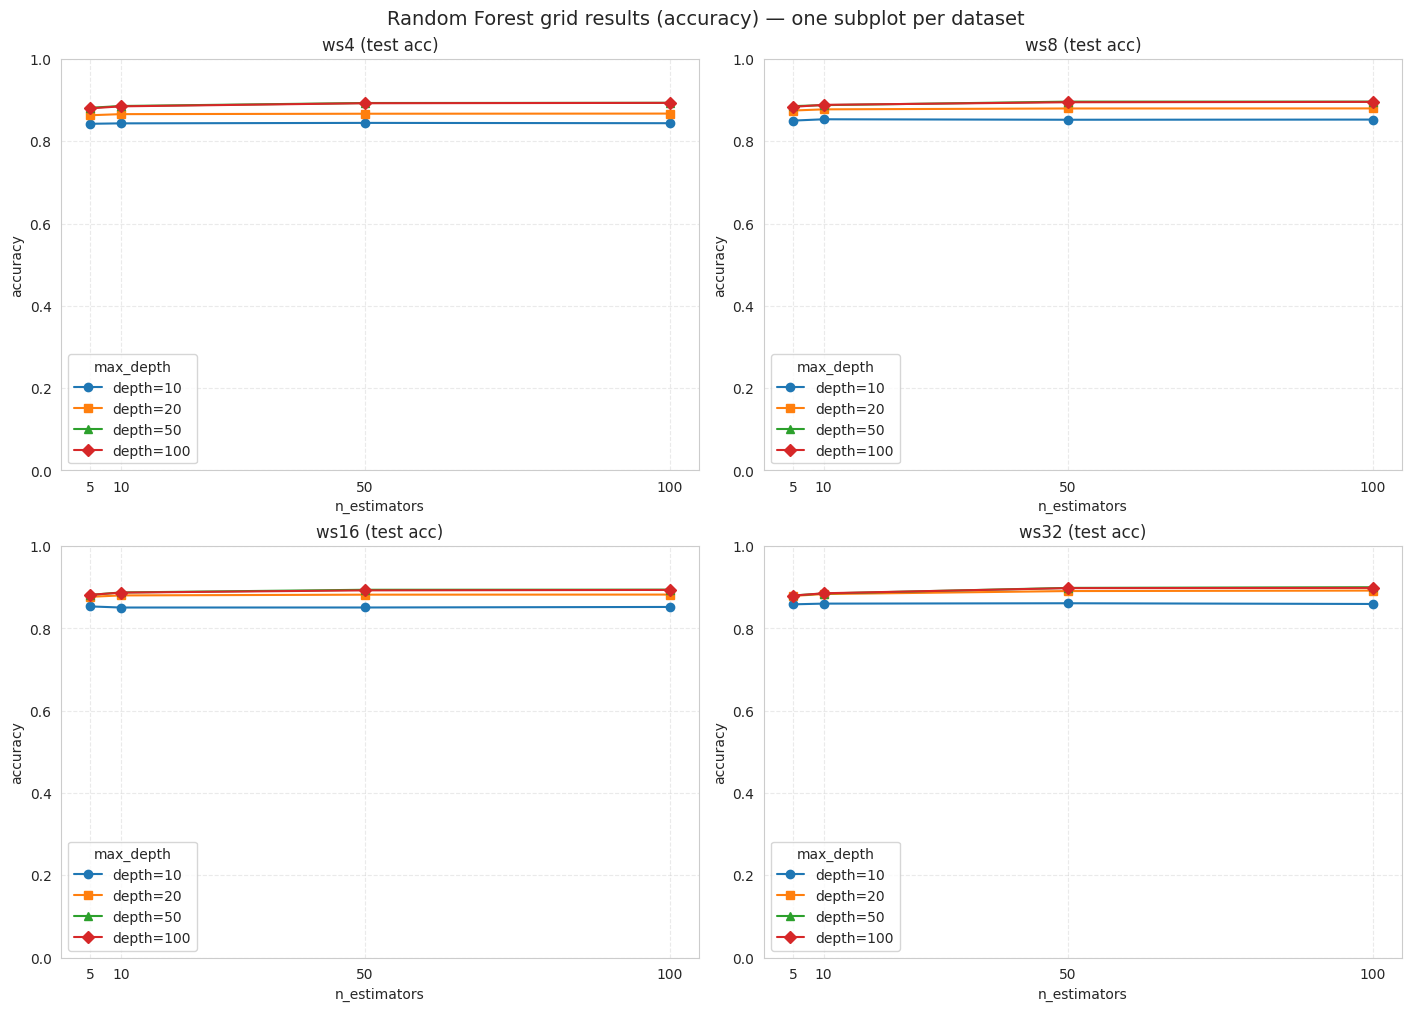

In [97]:
# results DataFrame
results_df = pd.DataFrame(rows)
if results_df.empty:
    print("\nNo completed runs (no files found). Exiting.")
else:
    # summary print
    pd.set_option('display.max_rows', None)
    print("\n\n=== Summary of results ===")
    print(results_df.groupby(['dataset','max_depth','n_estimators'])[['accuracy','roc_auc','avg_nodes_per_tree','total_nodes']].mean().reset_index().to_string(index=False))

    # Pivot for plotting: for each dataset, plot accuracy vs n_estimators with a line per depth
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
    axes = axes.flatten()
    dataset_list = results_df['dataset'].unique()
    palette = ['o', 's', '^', 'D']  # markers for depths

    for ax_i, ds_name in enumerate(datasets.keys()):
        ax = axes[ax_i]
        df_ds = results_df[results_df['dataset'] == ds_name]
        if df_ds.empty:
            ax.text(0.5, 0.5, f"No data for {ds_name}", ha='center', va='center')
            ax.set_title(ds_name)
            continue

        for i, depth in enumerate(sorted(df_ds['max_depth'].unique())):
            df_line = df_ds[df_ds['max_depth'] == depth].sort_values('n_estimators')
            ax.plot(
                df_line['n_estimators'],
                df_line['accuracy'],
                marker=palette[i % len(palette)],
                label=f"depth={depth}"
            )

        ax.set_xticks(estimators)
        ax.set_ylim(0, 1.0)
        ax.set_xlabel("n_estimators")
        ax.set_ylabel("accuracy")
        ax.set_title(f"{ds_name} (test acc)")
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend(title="max_depth")

    # hide any unused axes if fewer than 4 datasets ran
    for j in range(len(datasets), 4):
        if j < len(axes):
            axes[j].set_visible(False)

    out_png = "rf_grid_search_summary.png"
    plt.suptitle("Random Forest grid results (accuracy) — one subplot per dataset", fontsize=14)
    plt.savefig(out_png, dpi=150)
    print(f"\nPlot saved to: {out_png}")

    # Also print best configurations per dataset by accuracy
    print("\nBest configs per dataset (by accuracy):")
    bests = results_df.sort_values('accuracy', ascending=False).groupby('dataset').first().reset_index()
    print(bests[['dataset','max_depth','n_estimators','accuracy','roc_auc','avg_nodes_per_tree','total_nodes']].to_string(index=False))


Loading results from rf_grid_search_results.csv

Average accuracy per dataset (sorted):
dataset  avg_accuracy  std_accuracy  n_configs
   ws32      0.881938      0.014851         16
    ws8      0.878119      0.016841         16
   ws16      0.877592      0.016221         16
    ws4      0.871427      0.019418         16

Dataset with best average accuracy: ws32 (avg_accuracy=0.881938, std=0.014851, n_configs=16)


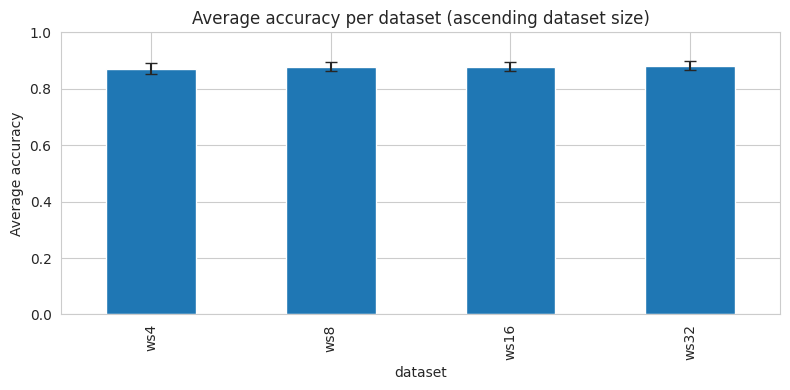

In [98]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If you already have a results CSV from the grid run, the script will use it.
RESULTS_CSV = "rf_grid_search_results.csv"

def summarize_from_df(results_df):
    # Group by dataset and compute mean accuracy (and std if you want)
    summary = (
        results_df.groupby("dataset")["accuracy"]
        .agg(["mean", "std", "count"])
        .rename(columns={"mean": "avg_accuracy", "std": "std_accuracy", "count": "n_configs"})
        .reset_index()
        .sort_values("avg_accuracy", ascending=False)
    )
    print("\nAverage accuracy per dataset (sorted):")
    print(summary.to_string(index=False, float_format="%.6f"))

    best = summary.iloc[0]
    print(f"\nDataset with best average accuracy: {best['dataset']} (avg_accuracy={best['avg_accuracy']:.6f}, std={best['std_accuracy']:.6f}, n_configs={int(best['n_configs'])})")

    # sort by dataset number (ws4, ws8, ws16, ws32)
    summary["dataset_num"] = summary["dataset"].str.extract(r"(\d+)").astype(int)
    summary = summary.sort_values("dataset_num")

    ax = summary.plot.bar(
        x="dataset",
        y="avg_accuracy",
        yerr="std_accuracy",
        legend=False,
        figsize=(8, 4),
        capsize=4
    )

    ax.set_ylabel("Average accuracy")
    ax.set_ylim(0, 1.0)
    ax.set_title("Average accuracy per dataset (ascending dataset size)")
    plt.tight_layout()
    plt.show()

    return summary

if os.path.exists(RESULTS_CSV):
    print(f"Loading results from {RESULTS_CSV}")
    results_df = pd.read_csv(RESULTS_CSV)
    summarize_from_df(results_df)
else:
    # If no CSV found, run the grid (this will retrain models; may take a while).
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, roc_auc_score
    from sklearn.model_selection import train_test_split

    datasets = {
        "ws4":  ("normal_ws4.csv",  "fault_ws4.csv"),
        "ws8":  ("normal_ws8.csv",  "fault_ws8.csv"),
        "ws16": ("normal_ws16.csv", "fault_ws16.csv"),
        "ws32": ("normal_ws32.csv", "fault_ws32.csv"),
    }

    numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']
    depths = [10, 20, 50, 100]
    estimators = [5, 10, 50, 100]

    rows = []

    for ds_name, (normal_file, fault_file) in datasets.items():
        if not (os.path.exists(normal_file) and os.path.exists(fault_file)):
            print(f"Skipping {ds_name}: missing files.")
            continue

        print(f"\nPreparing dataset {ds_name}")
        df_normal = pd.read_csv(normal_file)
        df_fault  = pd.read_csv(fault_file)
        df_normal['label'] = 0
        df_fault['label'] = 1
        df = pd.concat([df_normal, df_fault], ignore_index=True)
        df = df.drop(columns=['unit_id', 'reg_addr',
                              'ewma_mean', 'ewma_min', 'ewma_max', 'ewma_range',
                              'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
                     errors='ignore')
        for c in numeric_cols:
            df[c] = pd.to_numeric(df[c], errors='coerce')
        df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)
        X = df[numeric_cols]
        y = df['label'].astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        for max_depth in depths:
            for n_est in estimators:
                rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_est, n_jobs=4,
                                            random_state=42, bootstrap=False)
                rf.fit(X_train, y_train)
                y_pred = rf.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                try:
                    roc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
                except Exception:
                    roc = np.nan

                # record
                rows.append({
                    "dataset": ds_name,
                    "max_depth": max_depth,
                    "n_estimators": n_est,
                    "accuracy": acc,
                    "roc_auc": roc
                })
                print(f"{ds_name} depth={max_depth} est={n_est} -> acc={acc:.6f}")

    results_df = pd.DataFrame(rows)
    if results_df.empty:
        print("No results produced; check dataset files.")
    else:
        results_df.to_csv(RESULTS_CSV, index=False)
        print(f"\nSaved grid results to {RESULTS_CSV}")
        summarize_from_df(results_df)


#### extract JSON from PKL

In [ ]:
# import pickle

# with open("trained_models/rf_best_ws16.pkl", "rb") as f:
#     rf_ws16 = pickle.load(f)

# y_pred = rf_ws16.predict(X_new)
# y_prob = rf_ws16.predict_proba(X_new)[:, 1]


In [100]:
import os
import pickle
import json
from pathlib import Path

# --- reuse your rf_to_json function (copy/paste) ---
def rf_to_json(rf_model):
    rf_data = {
        'n_estimators': len(rf_model.estimators_),
        'max_depth': rf_model.max_depth,
        'feature_importances': rf_model.feature_importances_.tolist(),
        'estimators': []
    }

    for estimator in rf_model.estimators_:
        # build per-estimator dict
        estimators_data = {
            'n_nodes': int(estimator.tree_.node_count),
            'children_left': estimator.tree_.children_left.tolist(),
            'children_right': estimator.tree_.children_right.tolist(),
            'feature': estimator.tree_.feature.tolist(),
            'threshold': estimator.tree_.threshold.tolist(),
            'class_label': [],
            'leaves': []
        }

        # Extract per-node info (leaf indicator and class label for leaves)
        # estimator.tree_.value shape: (n_nodes, 1, n_classes) in scikit-learn
        values = estimator.tree_.value  # numpy array
        classes = estimator.classes_.tolist()  # e.g. [0,1]

        for i in range(int(estimator.tree_.node_count)):
            is_leaf = int(estimator.tree_.children_left[i] == estimator.tree_.children_right[i])
            estimators_data['leaves'].append(is_leaf)

            if is_leaf:
                # value[i,0] is counts for each class at this node
                class_counts = values[i, 0]
                max_class_index = int(class_counts.argmax())
                estimators_data['class_label'].append(int(classes[max_class_index]))
            else:
                estimators_data['class_label'].append(-10)

        rf_data['estimators'].append(estimators_data)

    return rf_data

# --- main processing ---
INPUT_DIR = Path("trained_models")
OUTPUT_DIR = Path("trained_models_json")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

if not INPUT_DIR.exists():
    raise SystemExit(f"Input directory not found: {INPUT_DIR.resolve()}")

pkl_files = sorted([p for p in INPUT_DIR.iterdir() if p.suffix.lower() in ('.pkl', '.joblib')])

if not pkl_files:
    print("No .pkl or .joblib files found in", INPUT_DIR)
else:
    print(f"Found {len(pkl_files)} model files. Converting to JSON into '{OUTPUT_DIR}'...\n")

for pkl_path in pkl_files:
    try:
        print(f"Loading {pkl_path.name} ...", end=' ')
        # prefer joblib if .joblib, otherwise pickle
        with open(pkl_path, "rb") as f:
            rf_model = pickle.load(f)

        print("ok. Converting...", end=' ')
        rf_json = rf_to_json(rf_model)

        json_name = pkl_path.stem + ".json"
        out_path = OUTPUT_DIR / json_name
        with open(out_path, "w") as jf:
            json.dump(rf_json, jf, indent=2)

        print(f"saved -> {out_path.name}")
    except Exception as e:
        print(f"\nERROR processing {pkl_path.name}: {e}")
        # optionally print more detail:
        # import traceback; traceback.print_exc()
        continue

print("\nDone.")


Found 64 model files. Converting to JSON into 'trained_models_json'...

Loading rf_ws16_depth100_est10.pkl ... ok. Converting... saved -> rf_ws16_depth100_est10.json
Loading rf_ws16_depth100_est100.pkl ... ok. Converting... saved -> rf_ws16_depth100_est100.json
Loading rf_ws16_depth100_est5.pkl ... ok. Converting... saved -> rf_ws16_depth100_est5.json
Loading rf_ws16_depth100_est50.pkl ... ok. Converting... saved -> rf_ws16_depth100_est50.json
Loading rf_ws16_depth10_est10.pkl ... ok. Converting... saved -> rf_ws16_depth10_est10.json
Loading rf_ws16_depth10_est100.pkl ... ok. Converting... saved -> rf_ws16_depth10_est100.json
Loading rf_ws16_depth10_est5.pkl ... ok. Converting... saved -> rf_ws16_depth10_est5.json
Loading rf_ws16_depth10_est50.pkl ... ok. Converting... saved -> rf_ws16_depth10_est50.json
Loading rf_ws16_depth20_est10.pkl ... ok. Converting... saved -> rf_ws16_depth20_est10.json
Loading rf_ws16_depth20_est100.pkl ... ok. Converting... saved -> rf_ws16_depth20_est100.jso